<a href="https://colab.research.google.com/github/PMartey/KaggleX-Project/blob/main/Preparing_Stock_trade_and_Ins_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Since the finance data set used in training the first gemma model
  answered prompts like on the slack app this really isn't factually accurate.  
  For instance the model couldnot explain what a checking account is, also so it couldn't differentiate between a checking and savings account.  
  The fine tuned model also had a low rouge and bleu score

#Import Necessary libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Prep Insuarance Dataset [Link to source](https://huggingface.co/datasets/sujra/insurance_llama2_145)

In [ ]:
ins_qa = pd.read_parquet("hf://datasets/sujra/insurance_llama2_145/data/train-00000-of-00001.parquet")
ins_qa.head()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,text
0,"<s>[INST] Understanding fund performance, NAV ..."
1,<s>[INST] What are the different types of life...
2,"<s>[INST] Define an """"Organisation-wide Policy..."
3,<s>[INST] Give some information about what inf...
4,<s>[INST] How does insurance underwriting work...


In [ ]:
# cleaning up the text format
# Removing <s> and </s> tags
ins_qa['text'] = ins_qa['text'].str.replace('<s>', '').str.replace('</s>', '')  # Replace 'text_column' with your actual column name

# removing \n and \n\n tags (new line character)
ins_qa['text'] = ins_qa['text'].replace('\n\n', '', regex=True).replace('\n', '', regex=True)
import re


# Function to extract question and answer
def split_question_answer(text):
    # Extract the question between [INST] and [/INST]
    question_match = re.search(r'\[INST\](.*?)\[/INST\]', text)
    # Extract the answer by removing the [INST]...[/INST] part
    answer = re.sub(r'\[INST\].*?\[/INST\]', '', text).strip()

    if question_match:
        question = question_match.group(1).strip()  # Extract and clean question
    else:
        question = None  # No question found

    return question, answer  # Return question and answer

# Apply the function to split the text into 'Question' and 'Answer' columns
ins_qa[['question', 'answer']] = ins_qa['text'].apply(lambda x: pd.Series(split_question_answer(x)))

In [ ]:
#Checking my data set
ins_qa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      140 non-null    object
 1   question  140 non-null    object
 2   answer    140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


In [ ]:
# Dropping the text column to include just q and a
ins_qna = ins_qa.drop(columns=['text'], inplace=True)

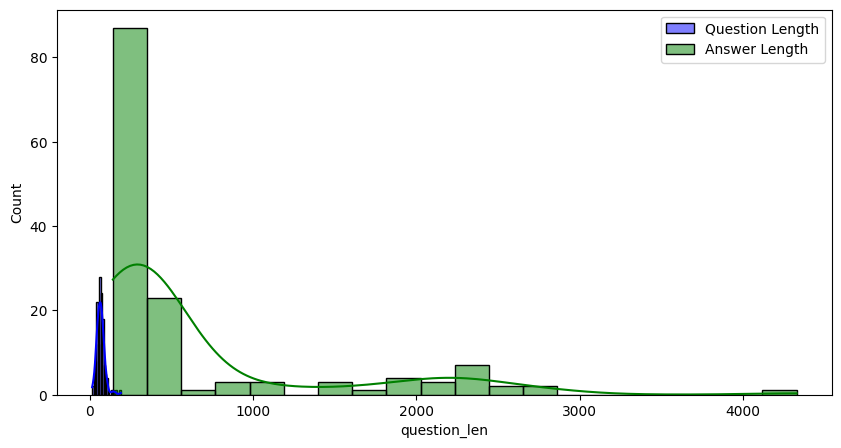

In [ ]:
# Visualize text length distributions for insurance data set
ins_qa['question_len'] = ins_qa['question'].apply(len)
ins_qa['answer_len'] = ins_qa['answer'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(ins_qa['question_len'], bins=20, kde=True, color='blue', label='Question Length')
sns.histplot(ins_qa['answer_len'], bins=20, kde=True, color='green', label='Answer Length')
plt.legend()
plt.show()

In [ ]:
ins_qa.describe()

,question_len,answer_len
count,140.000000,140.000000
mean,65.700000,645.800000
std,24.918775,771.836884
min,14.000000,141.000000
25%,49.000000,251.500000
50%,63.000000,292.500000
75%,77.250000,466.250000
max,190.000000,4329.000000


In [ ]:
ins_qa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      140 non-null    object
 1   answer        140 non-null    object
 2   question_len  140 non-null    int64 
 3   answer_len    140 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 4.5+ KB


# Trimming insurance dataset using extractive summarization



#Using Hugging Face Transformers for Extractive Summarization


In [ ]:
from transformers import pipeline

Example summary

In [ ]:

# Load a pre-trained summarization model
summarizer = pipeline("summarization")

# Summarize a long answer
text = ins_qa['answer'][1]  # Example text
summary = summarizer(text, max_length=100, min_length=30, do_sample=False)
print(summary[0]['summary_text'])


No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

 India offers a diverse range of life insurance plans to cater to various needs and financial goals . Traditional Life Insurance provides pure financial protection in case of the policyholder's death . Whole Life Insurance: Provides lifelong coverage and builds cash value over time . Critical Illness Insurance: Covers financial losses arising from accidental injuries or critical illnesses .


### Pipeline: Summarization Before Truncation

In [ ]:
# prompt: create a pipe line to summarize answers with lenght greater than 500

# Filter answers longer than 500 characters
long_answers = ins_qa[ins_qa['answer'].str.len() > 500]

# Apply summarization to long answers
summarized_answers = []
for answer in long_answers['answer']:
    try:
        summary = summarizer(answer, max_length=500, min_length=30, do_sample=False)
        summarized_answers.append(summary[0]['summary_text'])
    except:
        summarized_answers.append(answer)  # If summarization fails, use the original answer

# Create a new DataFrame with summarized answers
summarized_df = pd.DataFrame({
    'question': long_answers['question'],
    'original_answer': long_answers['answer'],
    'summarized_answer': summarized_answers
})

summarized_df

Your max_length is set to 500, but your input_length is only 410. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=205)
Your max_length is set to 500, but your input_length is only 487. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=243)
Your max_length is set to 500, but your input_length is only 343. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=171)
Your max_length is set to 500, but your input_length is only 382. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=1

,question,original_answer,summarized_answer
1,What are the different types of life insurance...,India offers a diverse range of life insurance...,India offers a diverse range of life insuranc...
12,"Why is travel insurance important, especially ...",While travel often conjures images of adventur...,Travel insurance offers a safety net and fina...
13,What factors should I consider when choosing a...,Choosing the right life insurance policy depen...,Choosing the right life insurance policy depe...
15,How can I calculate the sum insured for my hom...,Calculating the right sum insured for your hom...,Calculating the right sum insured for your ho...
16,How is insurance premium calculated?,The calculation of an insurance premium involv...,The calculation of an insurance premium invol...
17,What documents are required to renew my motor ...,Renewing your motor insurance policy is crucia...,Renewing your motor insurance policy is cruci...
25,Is personalized agent support from LIC a signi...,LIC's personalized agent support provides poli...,LIC's personalized agent support provides pol...
26,Highlight the features and flexibility of HDFC...,HDFC Life's Click 2 Protect Life term plan off...,HDFC Life's Click 2 Protect Life term plan of...
31,How does cashless health insurance work?,Cashless health insurance offers a convenient ...,Cashless health insurance offers a convenient...
47,What are the eligibility criteria for LIC's Ca...,"LIC's Cancer Cover Plan (Plan No. 905, UIN No....","LIC's Cancer Cover Plan (Plan No. 905, UIN No..."


In [ ]:
summarized_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, 1 to 137
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   question           32 non-null     object
 1   original_answer    32 non-null     object
 2   summarized_answer  32 non-null     object
dtypes: object(3)
memory usage: 1.0+ KB


For now I am not including summarized_df to the data set

In [ ]:
ins_df = ins_qa[ins_qa['answer'].str.len() < 500]
ins_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 108 entries, 0 to 139
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      108 non-null    object
 1   answer        108 non-null    object
 2   question_len  108 non-null    int64 
 3   answer_len    108 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ KB


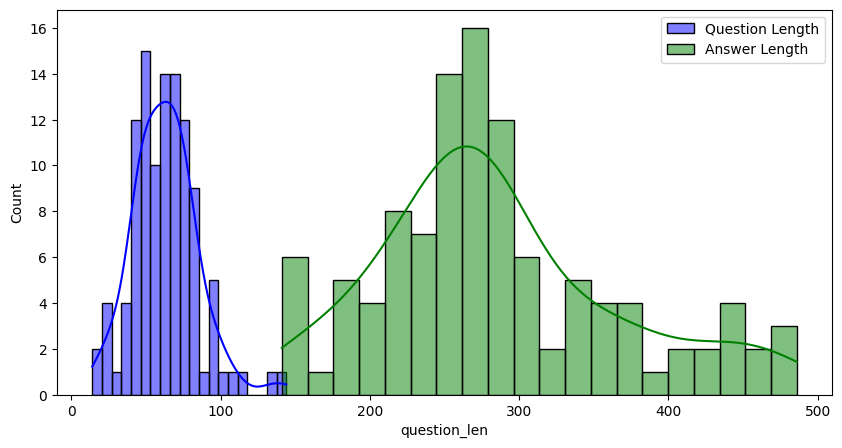

In [ ]:
# Visualize text length distributions for shorter responses of insurance data set

plt.figure(figsize=(10, 5))
sns.histplot(ins_df['question_len'], bins=20, kde=True, color='blue', label='Question Length')
sns.histplot(ins_df['answer_len'], bins=20, kde=True, color='green', label='Answer Length')
plt.legend()
plt.show()

In [ ]:
## Another form of truncation
'''max_question_len = 200  # Example threshold for question length
max_answer_len = 500    # Example threshold for answer length

# Truncate long questions and answers
ins_qa['question'] = ins_qa['question'].apply(lambda x: x[:max_question_len])
ins_qa['answer'] = ins_qa['answer'].apply(lambda x: x[:max_answer_len])
'''

## Prep Stock trading QnA [link to source](https://huggingface.co/datasets/yymYYM/stock_trading_QA)

In [ ]:
import pandas as pd

st_qna = pd.read_csv("hf://datasets/yymYYM/stock_trading_QA/stock_trading_qa_pairs_processed.csv")
st_qna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7165 non-null   int64 
 1   question    7165 non-null   object
 2   answer      7165 non-null   object
dtypes: int64(1), object(2)
memory usage: 168.1+ KB


In [ ]:
st_qna.columns
#st_qna.info()

Index(['Unnamed: 0', 'question', 'answer'], dtype='object')

In [ ]:
st_qna.head()

,Unnamed: 0,question,answer
0,0,What is the ARIMA model and how does it help i...,ARIMA models combine autoregressive (AR) and m...
1,1,What role does automation play in event-driven...,Automation helps traders execute trades quickl...
2,2,Can fundamental analysis complement trading si...,"Yes, fundamental analysis can complement tradi..."
3,3,How is stock price momentum calculated?,Stock price momentum is typically calculated b...
4,4,What is a stop-loss order in stock trading?,A stop-loss order is an order placed with a br...


In [ ]:
# Dropping Unnamed:0 column to include just q and a
st_qna1 = st_qna.drop(columns=['Unnamed: 0'], inplace= True)


In [ ]:
#st_qna1 = st_qna.sample(n=145, random_state=42)

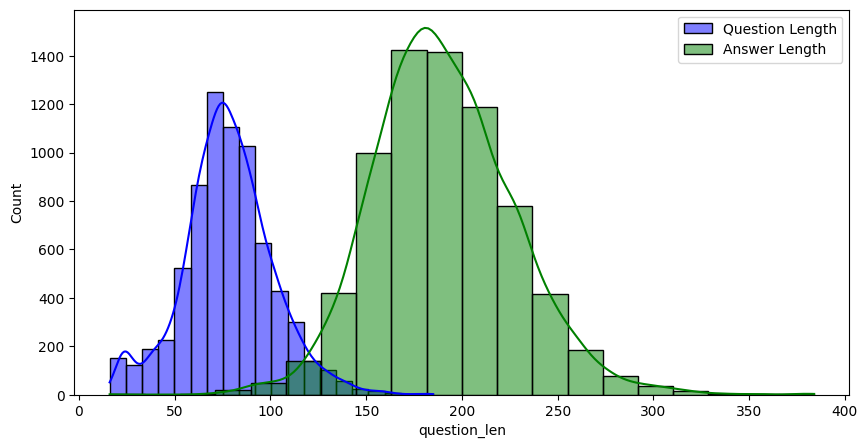

In [ ]:
# Visualize text length distributions for insurance data set
st_qna['question_len'] = st_qna['question'].apply(len)
st_qna['answer_len'] = st_qna['answer'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(st_qna['question_len'], bins=20, kde=True, color='blue', label='Question Length')
sns.histplot(st_qna['answer_len'], bins=20, kde=True, color='green', label='Answer Length')
plt.legend()
plt.show()

## Merge and Explore data set


In [ ]:
from typing_extensions import final
final_df = pd.concat([ins_df, st_qna], axis=0)

# since i merge 2 data sets together I have to mix them before training
final_df = final_df.sample(frac=1).reset_index(drop=True)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   question      7273 non-null   object
 1   answer        7273 non-null   object
 2   question_len  7273 non-null   int64 
 3   answer_len    7273 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 227.4+ KB


So I am treating the data set seperately to see how they perform.
Because the insurance data set is right tailed so needs to be trimed
Where as the stock trading data set is normally distributed

In [ ]:
# there are no null values
qna_df = final_df

def clean_text(text):
    #text = text.str.lower()  # Lowercase using .str.lower() for Series
    text = text.str.replace(r'\s+', ' ', regex=True)  # Remove extra whitespace
    text = text.str.replace(r'<.*?>', '', regex=True)  # Remove HTML tags if present
    # Remove special characters except alphanumeric and common punctuation for questions/answers
    text = text.str.replace(r'[^A-Za-z0-9\s\.,!?[\]""]', '', regex=True)
    return text


# Apply cleaning
qna_df['question'] = clean_text(qna_df['question'])
qna_df['answer'] = clean_text(qna_df['answer'])

print(qna_df)

                                               question  \
0     What is the BlackScholes model and how is it u...   
1     What role does industrial production data play...   
2     How does market liquidity influence the detect...   
3     What are some common techniques used to detect...   
4     How do you incorporate economic indicators int...   
...                                                 ...   
7268           How is quantitative momentum calculated?   
7269  What is a bullish crossover signal in trading ...   
7270  How do sentiment analysis models adapt to chan...   
7271  Why is it important to detect anomalies in sto...   
7272  Can adaptive trading algorithms be programmed ...   

                                                 answer  question_len  \
0     The BlackScholes model is a mathematical formu...            94   
1     Industrial production data reflects manufactur...           108   
2     Market liquidity affects the detection of anom...            79   

In [ ]:
# Select rows not in english other language
qna_df['question'].apply(lambda text: bool(re.search(r'[^\x00-\x7F]+', text)))

,question
0,False
1,False
2,False
3,False
4,False
...,...
7268,False
7269,False
7270,False
7271,False


In [ ]:
# Check for duplicates
print(f"Duplicate question-answer pairs: {qna_df.duplicated(['question', 'answer']).sum()}")
qna_df1 = qna_df.drop_duplicates(subset=['question', 'answer'])



Duplicate question-answer pairs: 12


<ipython-input-25-9435b71212ea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1['question_len'] = qna_df1['question'].apply(len)
<ipython-input-25-9435b71212ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1['answer_len'] = qna_df1['answer'].apply(len)


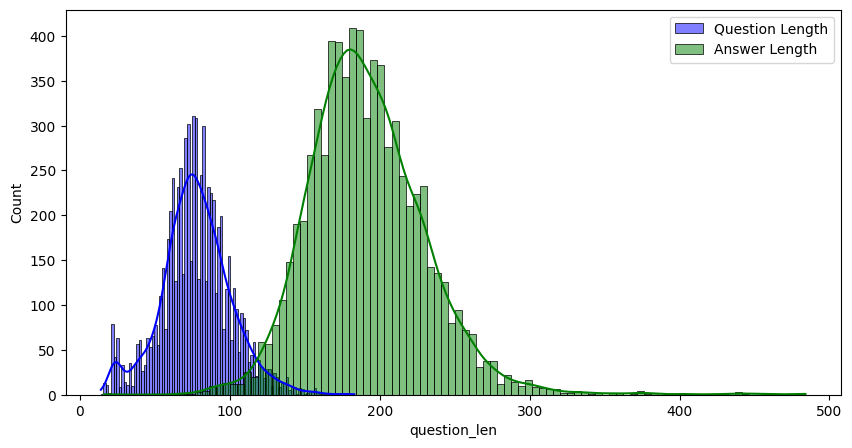

In [ ]:
# Visualize text length distributions
qna_df1['question_len'] = qna_df1['question'].apply(len)
qna_df1['answer_len'] = qna_df1['answer'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(qna_df1['question_len'], bins=100, kde=True, color='blue', label='Question Length')
sns.histplot(qna_df1['answer_len'], bins=100, kde=True, color='green', label='Answer Length')
plt.legend()
plt.show()

In [ ]:
qna_df1.drop(columns=['question_len', 'answer_len'], inplace=True)

<ipython-input-26-a26fbbb4beb1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qna_df1.drop(columns=['question_len', 'answer_len'], inplace=True)


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(qna_df1, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv('train2_data.csv', index=False)
val_df.to_csv('val2_data.csv', index=False)
test_df.to_csv('test2_data.csv', index=False)